In [137]:
import pandas as pd
import numpy as np
import statsmodels
# visualization
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5) # faire en sorte que les plots s'affiche assez large sur tout le notebook

C:\Users\luca5\AppData\Local\Temp\ipykernel_16452\2032417400.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('datasets/RenewableEnergyTexas.csv',parse_dates = ['Date'], index_col= ['Date'], header=0)


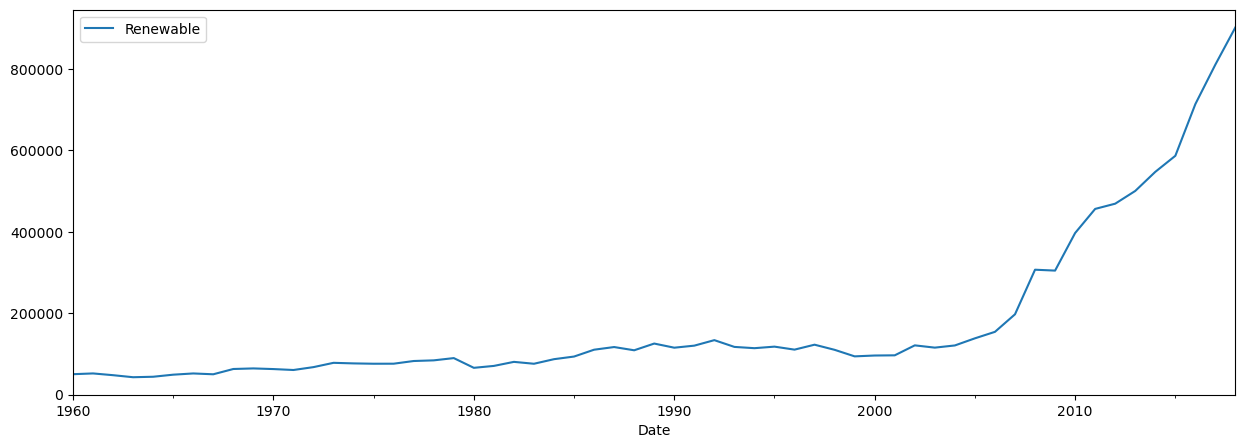

In [138]:
# df = pd.read_csv('datasets/Brent_Spot_Price.csv', header=0, index_col=0, parse_dates=['date'])
df = pd.read_csv('datasets/RenewableEnergyTexas.csv',parse_dates = ['Date'], index_col= ['Date'], header=0)
# df.index = pd.to_datetime(df.index)
df_plot = df.plot()
fig = df_plot.get_figure()
fig.set_size_inches(15, 5)

## Afficher la moyenne et variance mobile

Renewable    3.919550e+10
dtype: float64


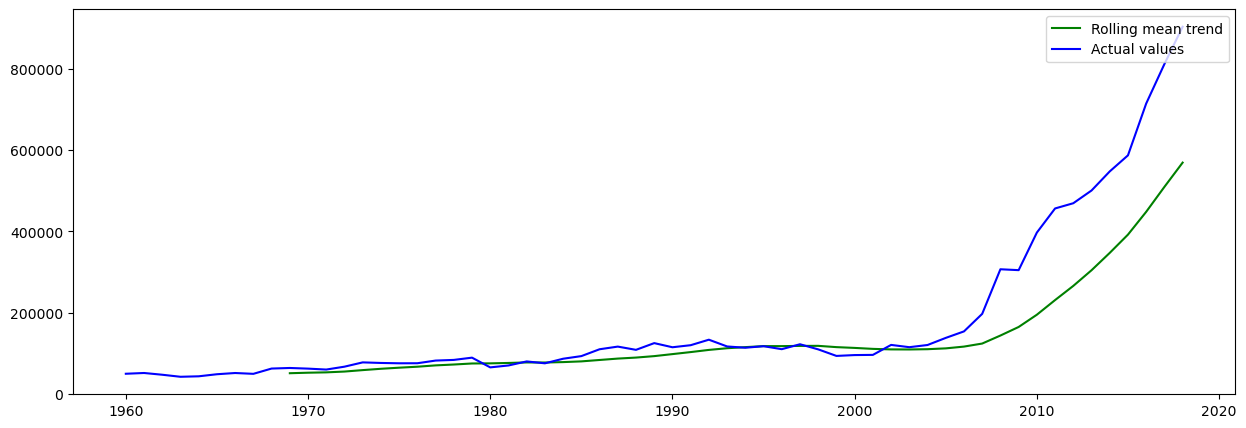

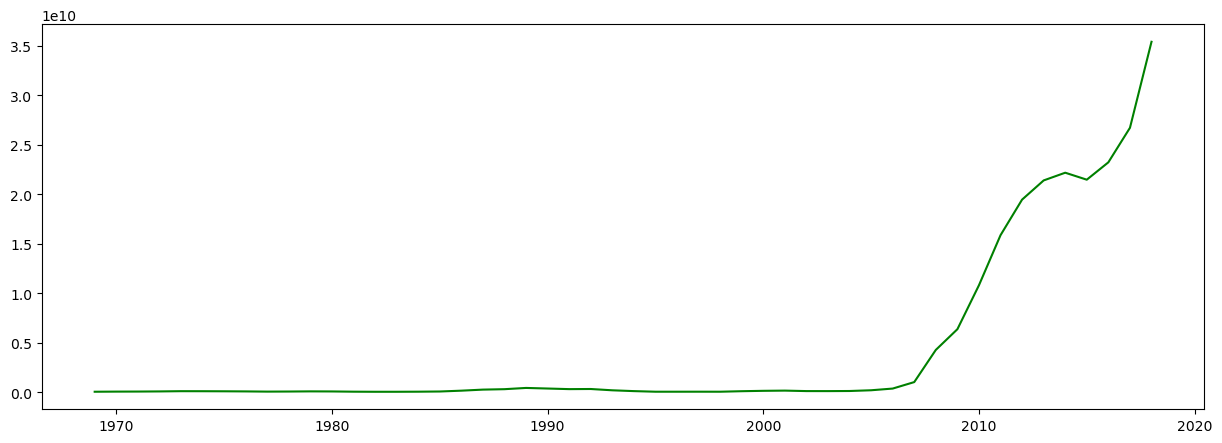

In [139]:
def plot_rolling_mean_and_var(series, window=10):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15,5))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.plot(series, "b", label="Actual values")
    leg = plt.legend(loc='upper right')
    
    series_var = series.var()
    print(series_var)
    rolling_var = series.rolling(window=window).var()
    plt.figure(figsize=(15,5))
    plt.plot(rolling_var, "g", label="Rolling variance")
    
plot_rolling_mean_and_var(df)

On voit que la variance augment quand la moyenne augmente. Et la variance augmente fortement. Cela signifie qu'on a un phénomène ayant une tendance exponentielle, il serait pertinent d'appliquer la transformation `log`

In [140]:
df_log = np.log(df)

Renewable    0.623418
dtype: float64


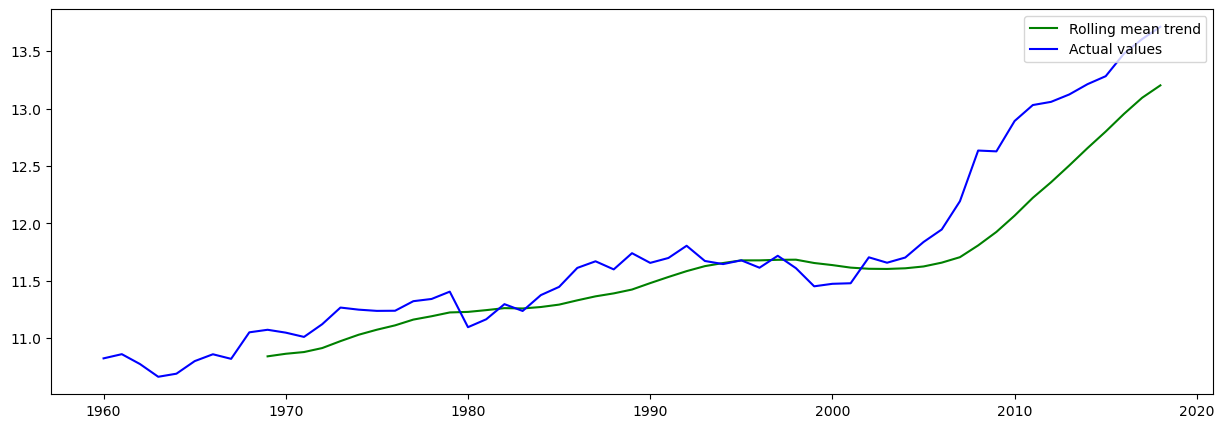

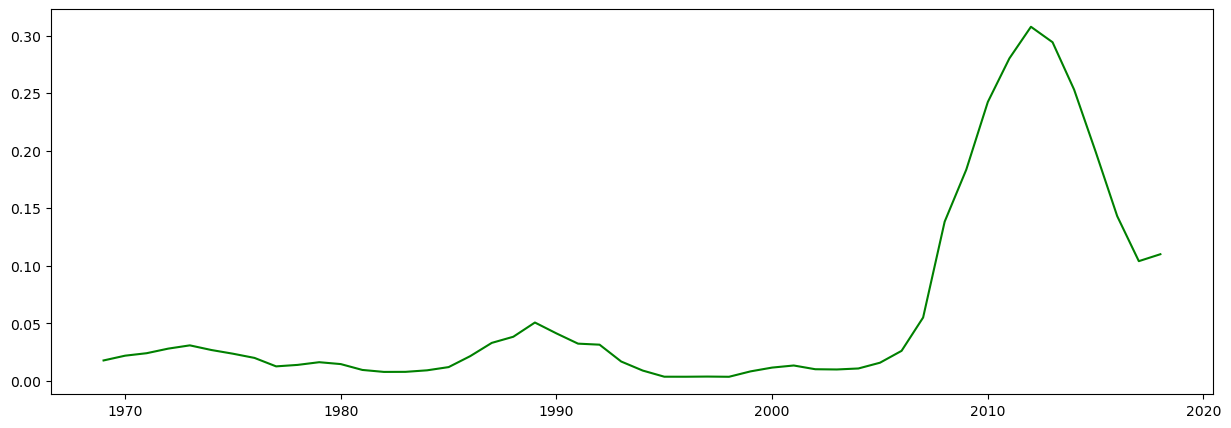

In [141]:
plot_rolling_mean_and_var(df_log)

## Afficher les plots ACF et PACF

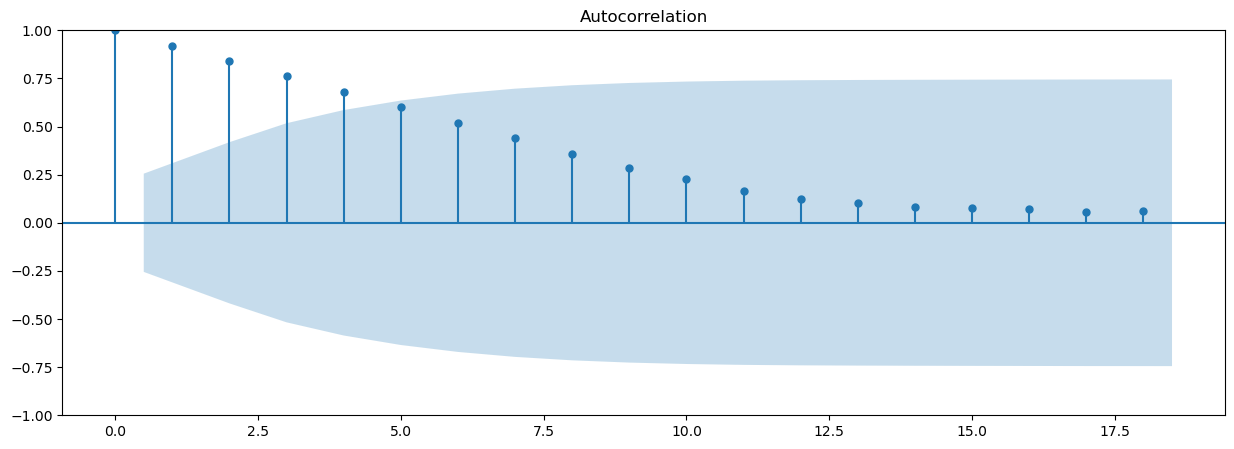

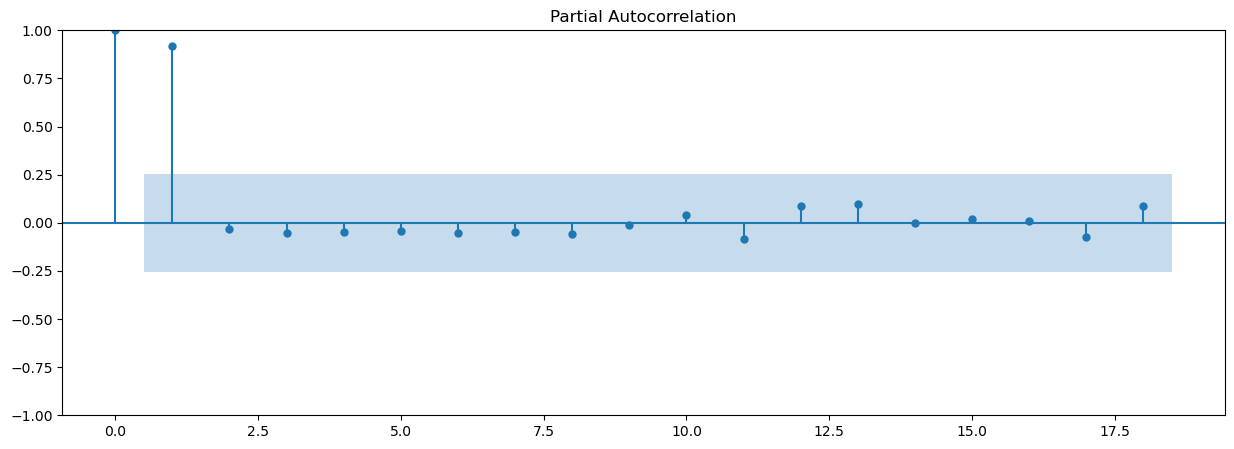

In [142]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_ = plot_acf(df_log)
_ = plot_pacf(df_log)

Sans même faire de test ADF on peut voir sur le PACF que l'énorme pic à 1 indique que la série est très autocorrelée avec son décalage de 1, on peut donc **différencier** la série avec un ordre de 1

c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


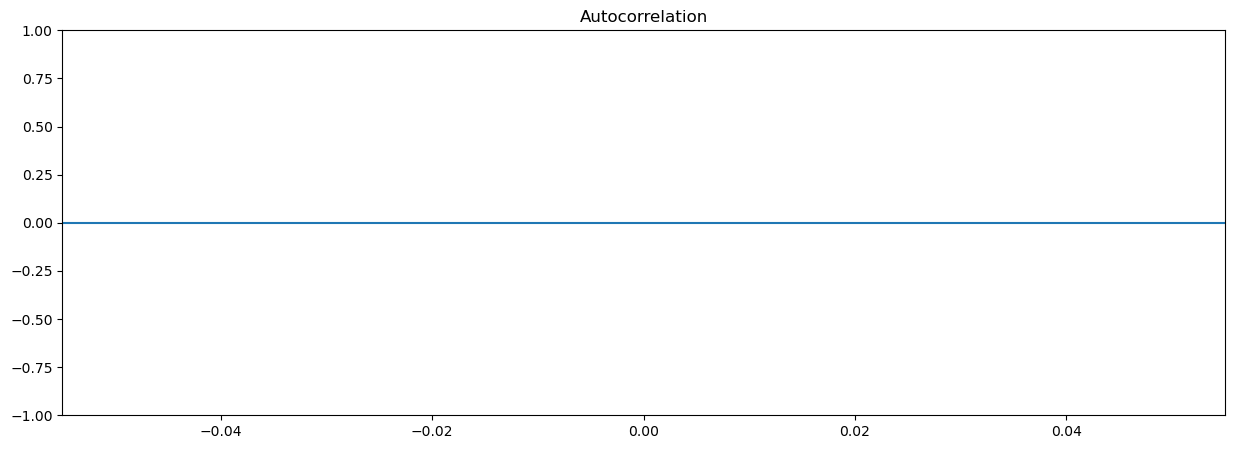

In [143]:
df_diff = df_log.diff()
_ = plot_acf(df_diff)

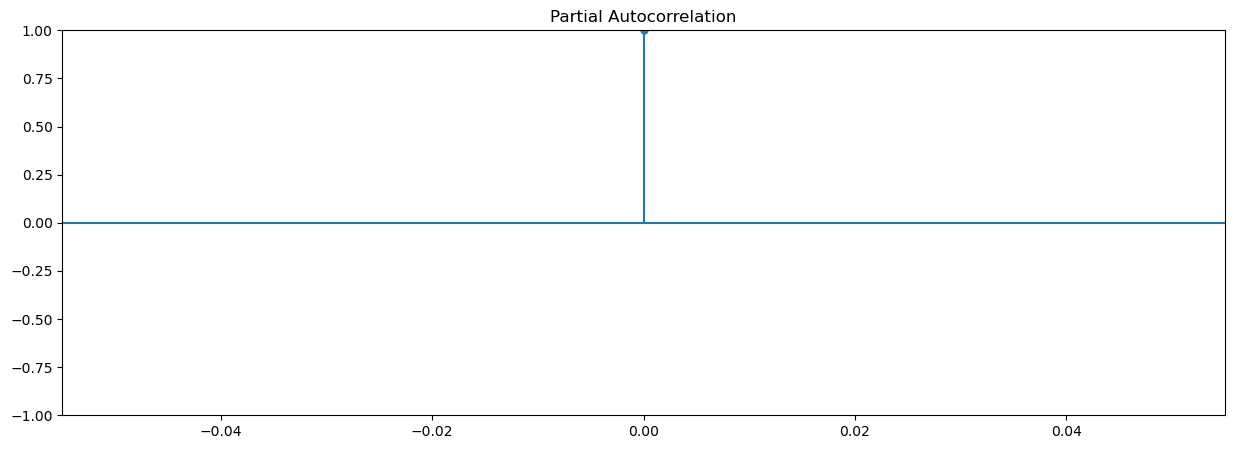

In [144]:
_ = plot_pacf(df_diff)

Renewable    0.01411
dtype: float64


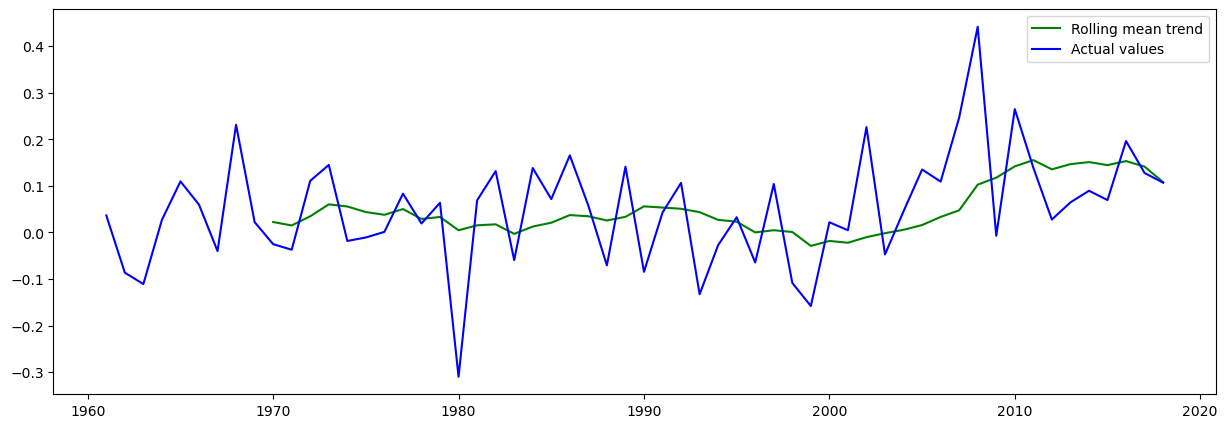

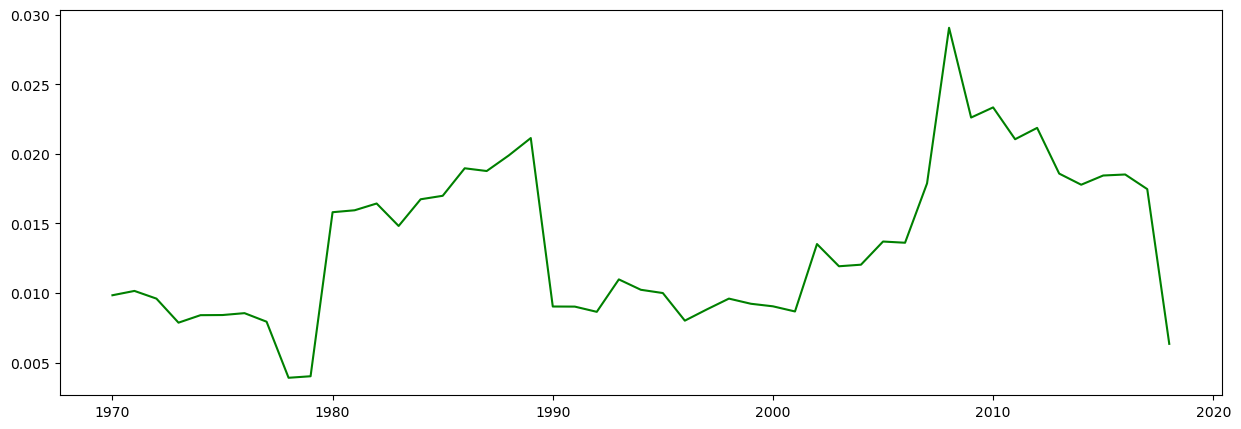

In [145]:
plot_rolling_mean_and_var(df_diff)

In [63]:
from statsmodels.tsa.stattools import adfuller

def adf(series):
    t_stat, p_value, used_lag, nobs, critical_values, _  = adfuller(series.values, autolag='AIC')
    print(f'ADF Statistic: {t_stat:.2f}')
    print(f'Used lag: {used_lag:.2f}')
    print(f'Number of observations used: {nobs:.2f}')
    print(f'p-value: {p_value:.2f}')
    for key, value in critical_values.items():
        print('Critical Values:')
        print(f'   {key}, {value:.2f}')

adf(df_diff)

ADF Statistic: -3.05
Used lag: 2.00
Number of observations used: 55.00
p-value: 0.03
Critical Values:
   1%, -3.56
Critical Values:
   5%, -2.92
Critical Values:
   10%, -2.60


On a un bien une p-value inférieur à 0.03 et donc un phénomène stationnaire.

Essayons donc ARIMA avec d = 1 et trouvons les autres paramètres.

Pour les paramètre d'ARIMA, regardons à nouveau les ACF et PACF avec la différenciation d'ordre 1.

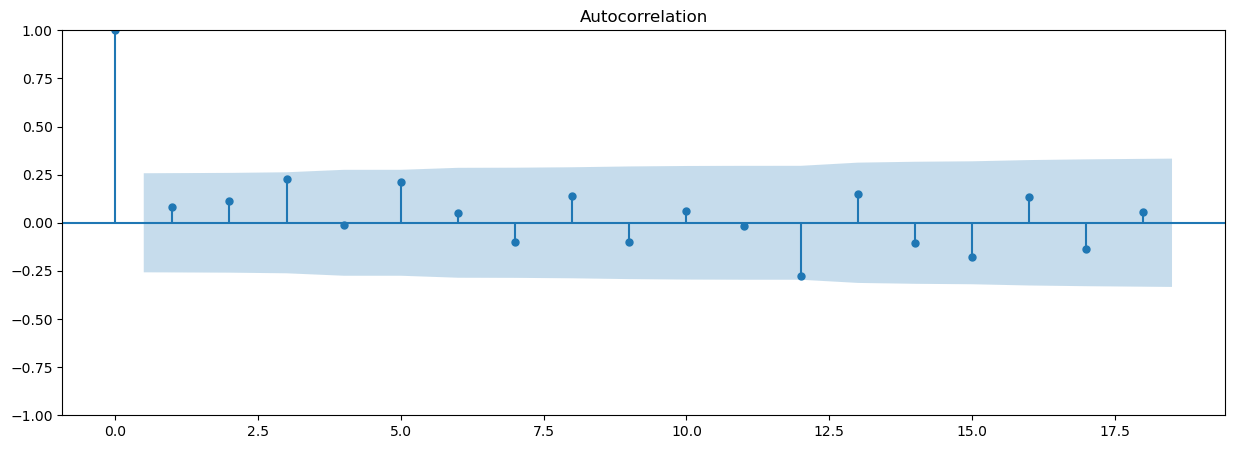

In [64]:
_ = plot_acf(df_diff)

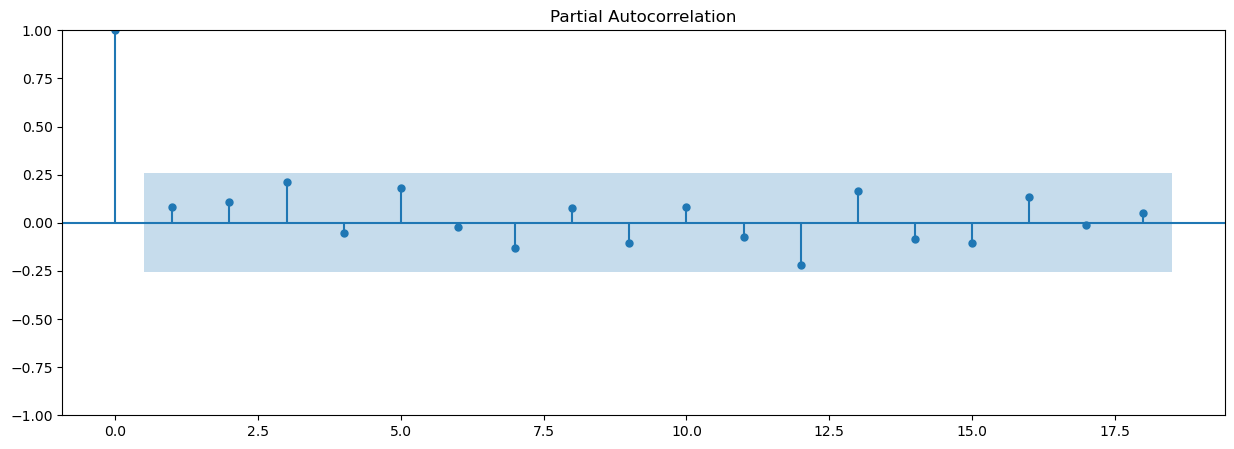

In [65]:
_ = plot_pacf(df_diff)

### Pas de saisonnalité car pas de pic éloigné.

### Pour l'ordre d'Auto Regression AR(p), on regarde le PACF. Si les lags 1 et 2 étaient fort, cela nous indiquerait qu'on aurait un AR d'ordre 1 ou 2 au moins. On aurait donc p = 1 ou p = 2. Même logique si seulement le lag 1 était fort, on aurait p=1.

### Pour l'ordre Moving Average, on regarde l'ACF et on applique la même logique avec les lags les plus significatifs. On verrait donc si on a q = 0, 1, 2 ou plus (plus rare).

## Même si on observe plus de pics dans l'autocorrélogramme, on peut tester ARIMA avec des paramètres basiques sans saisonnalité (p, d q) = (1,1,1)

In [66]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_log, order=(1,1,1))
model = arima_model.fit()
print(model.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible start

                               SARIMAX Results                                
Dep. Variable:              Renewable   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  41.745
Date:                Wed, 19 Jun 2024   AIC                            -77.490
Time:                        14:27:02   BIC                            -71.309
Sample:                    01-01-1960   HQIC                           -75.082
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9525      0.166      5.750      0.000       0.628       1.277
ma.L1         -0.8111      0.242     -3.355      0.001      -1.285      -0.337
sigma2         0.0138      0.002      5.696      0.0

#### 2 informations importantes : Premièrement, le critère AIC, un score AIC plus petit indique un modèle plus prédictif.
#### Deuxièmement, les coefficients pour chacun de nos paramètres. Ici on a un coéfficient d'AR et un de MA. On peut voir leur signification statistique dans la colonne P>|z|, qui est la p-value et doit être inférieure à 0.05 pour considérer le coefficient comme statistiquement significatif.
#### Ici on voit bien qu'ils sont tous inférieurs à 0.05 et donc significatifs

#### Regardons maintenant les residuals. Les residuals sont les restes non expliqués par notre modèle. Idéalement, ils doivent être aléatoires et donc non prévisible. S'il reste des tendances ou autres signes non aléatoire, cela veut dire qu'il y a une partie que notre modèle n'a pas expliqué.

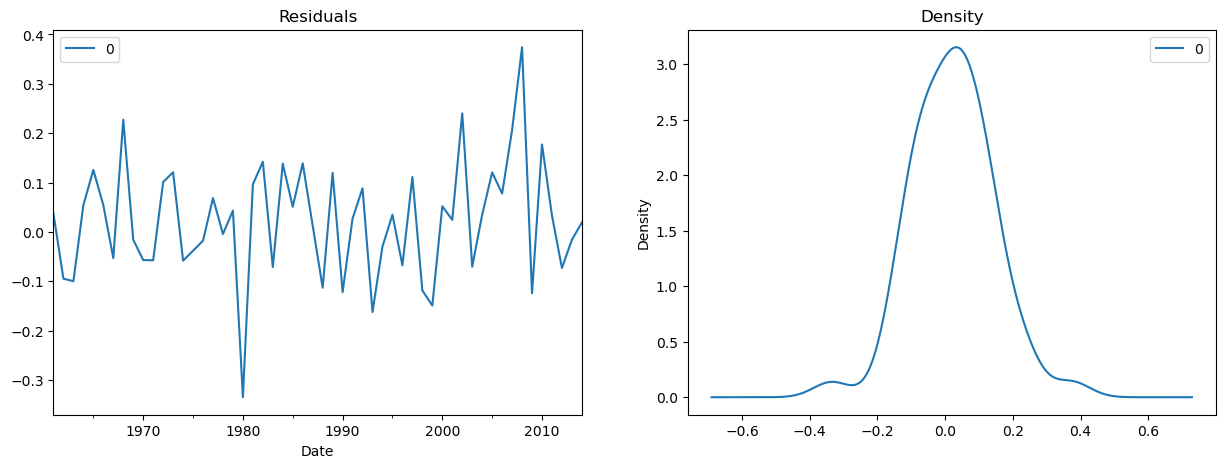

In [148]:
residuals = pd.DataFrame(model.resid[1:])

# on enlève le premier point car comme on a différencié de 1 le modèle est incapable de fournir des prédictions
# correctes pour un point dont on n'a pas l'information nécessaire (la valeur du point précédent pour différencier)

fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Les graphiques c'est bien, les tests statistiques c'est mieux

In [149]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# test d'autocorrélation des résidus
print('Retard : p-value')
for lag in [1, 6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(residuals, lags=lag, return_df=False)['lb_pvalue'].mean()))
    

Retard : p-value
1 : 0.38826511329166513
6 : 0.5383655847812159
12 : 0.5012097245699307
18 : 0.3543954672142113
24 : 0.27898491373237505
30 : 0.2350711999103971
36 : 0.20790943172495305


Pas d'autocorrélation

In [106]:
from scipy.stats import shapiro

# test de normalité des résidus
shapiro(model.resid[1:]) 

# on enlève bien le premier point ici aussi car comme on a différencié de 1 le modèle est incapable de fournir des
# prédictions correctes pour un point dont on n'a pas l'information nécessaire (la valeur du point précédent pour différencier)

ShapiroResult(statistic=0.980741319622581, pvalue=0.5326078258911335)

Normalité des résidus bien vérifiée

#### Nos résidus son non autocorrélées et suivent une distribution normale, cela indique qu'on a réussi à modeliser une partie assez significative de notre time series

#### Essayons maitenant d'afficher les prédictions du modèle par rapport au réel

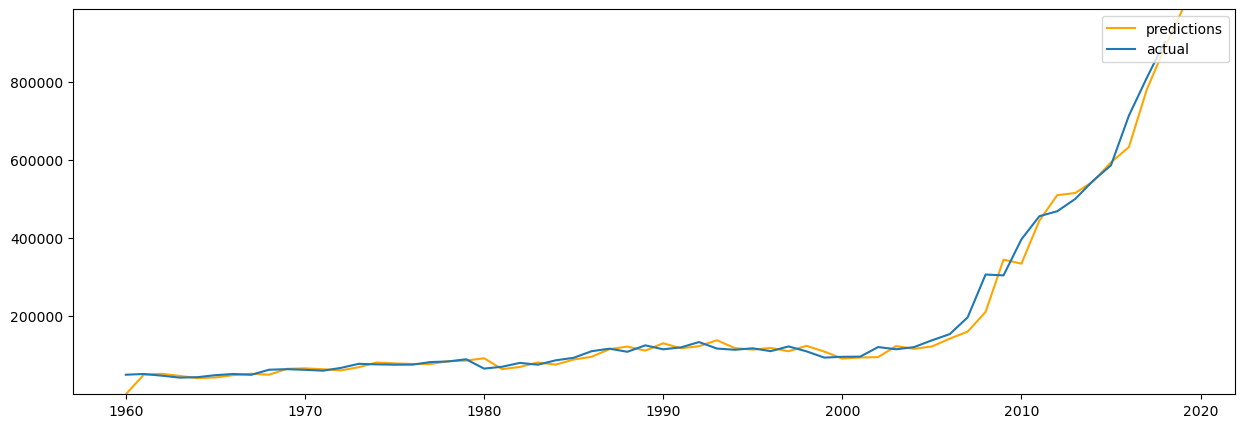

In [43]:
from statsmodels.graphics.tsaplots import plot_predict
# plot = plot_predict(model, dynamic=False)
def plot_predictions(series, predictions):
    
    
    plt.plot(predictions, color = "orange", label="predictions")
    plt.plot(series, label="actual")

    leg = plt.legend(loc='upper right')

    max_value = max(max(predictions.values), max(series))
    min_value = min(min(predictions.values), min(series))
    ax = plt.gca()
    ax.set_ylim(min_value, max_value)

    plt.show()
    
predictions = model.predict(0, len(df)) # prédire du début à la fin, pour toutes les valeurs

plot_predictions(df.Renewable, np.exp(predictions))

### Maintenant nous allons essayer de faire prédire des valeurs "futures" à notre modèle. Pour cela nous allons lui montrer seulement une partie du dataset, qui va être la partie d'entraînement. On va ensuite comparer ses prédictions aux vrais valeurs, le jeu de test.

In [73]:
train = np.log(df.Renewable[:55]) # toutes sauf les 4 dérnières (c'est un exemple)
test = np.log(df.Renewable[55:])

In [74]:
arima_model = ARIMA(train, order=(1, 1, 1))  
model = arima_model.fit() 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible start

MAPE = 13.93%


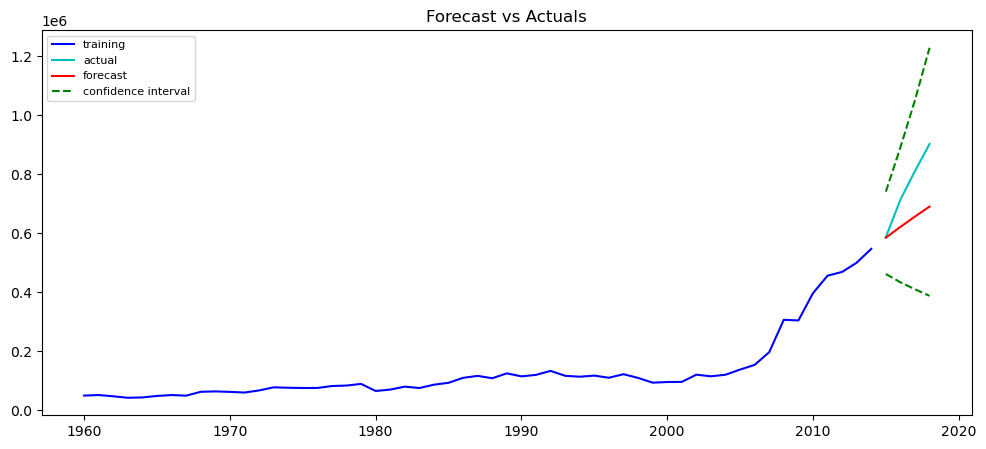

In [132]:
def make_forecast(model, train, test, fc_length):
    fc = model.get_forecast(fc_length)
    fc_mean = np.exp(fc.predicted_mean)
    y_pred_inf = np.exp(fc.conf_int(alpha=0.05)['lower Renewable'])
    y_pred_sup = np.exp(fc.conf_int(alpha=0.05)['upper Renewable'])

    
    mape = np.mean(np.abs(fc_mean - test)/np.abs(test)*100)  # MAPE
    print(f"MAPE = {mape:.2f}%")
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training', color = 'b')
    plt.plot(test, label='actual', color = 'c')
    plt.plot(fc_mean, label='forecast', color='r')
    plt.plot(y_pred_inf.index, y_pred_inf, label='confidence interval', color='g', linestyle='--')
    plt.plot(y_pred_sup.index, y_pred_sup, color='g', linestyle='--')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
make_forecast(model, np.exp(train), np.exp(test), len(test))

### Pas mal. Pourquoi pas essayer avec d'autres paramètres.